### import modules

In [3]:
from __future__ import division
from __future__ import print_function

from cvxpy import *
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
sns.set()

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### define functions

In [46]:
def f_hat_compute(K,alpha_hat):
    f_hat = np.dot(alpha_hat,K)
    
    return f_hat

def LOOCV_rbf(x,y,lambda_vec,gamma_vec):
    
    cost_vec = np.zeros((lambda_vec.shape[0],gamma_vec.shape[0]))
    lambda_iter = 0
    
    for lambda_val in lambda_vec:
        
            gamma_iter = 0
            
            for gamma_ind in gamma_vec:
                print('lambda = {},gamma = {}'.format(lambda_val,gamma_ind))


                score_ind = []
            
                for valid_ind in np.arange(y.shape[0]):
                    mask = np.ones(np.shape(y))
                    mask[valid_ind] = 0
                    mask = mask.astype('bool')
                    y_train = y[mask]
                    y_test = y[valid_ind]
                    x_train = x[mask]
                    x_test = x[valid_ind]

                    K = make_K_mat_rbf(x_train,gamma_ind)
                    alpha_hat = alpha_hat_compute(K,lambda_val,y_train)

                    eval_kernel = kernel_eval_rbf(gamma,x_test,x_train)
                    predict_y = np.array([np.sum(alpha_hat.flatten()*eval_kernel)])
                    cost_ind = cost_func(predict_y,y_test)
                    score_ind.append(cost_ind)


                score = (1/len(score_ind))*np.sum(score_ind)
                cost_vec[lambda_iter][gamma_iter] = score
                
                gamma_iter += 1 
        
            lambda_iter += 1
    
    return cost_vec

def cost_func(prediction,truth):
    
    cost = []
    
    for i in np.arange(prediction.shape[0]):
        
        cost.append(np.linalg.norm(prediction[i]-truth[i]))
    
    cost_total = np.sqrt(np.sum(cost))
    return cost_total

def make_K_mat_rbf(x,gamma):
    K = np.zeros((x.shape[0],x.shape[0]))
    
    for i in np.arange(x.shape[0]):
        for j in np.arange(x.shape[0]):
            K[i][j] = np.exp(-gamma*(np.linalg.norm(x[i]-x[j])**2))
            
    return K

def kernel_eval_rbf(gamma,x_1,x_2):
    eval_kernel = []
    
    for i in np.arange(x_2.shape[0]):
        eval_iter = float(np.exp(-gamma*(np.linalg.norm(x_1-x_2[i])**2)))
        eval_kernel.append(eval_iter)
    return eval_kernel 

def bootstrap_rbf(gamma,lambda_val,x,y,data,num_sets,num_pulls):
    bootstrapped_examples = np.zeros((num_sets,data.shape[0]))
    inds = np.arange(num_pulls)
    for j in np.arange(num_sets):
        inds_choice = np.random.choice(inds,num_pulls)
        x_samp = x[inds_choice]
        y_samp = y[inds_choice]

        f_hat = np.zeros((data.shape))

        K = make_K_mat_rbf(x_samp,gamma)
        alpha_hat = alpha_hat_compute(K,lambda_val,y_samp)

        for i in np.arange(data.shape[0]):
            eval_kernel = kernel_eval_rbf(gamma,float(data[i]),x_samp)
            predict_y = np.sum(alpha_hat.flatten()*np.array(eval_kernel))

            f_hat[i] = predict_y
        
        bootstrapped_examples[j,:] = f_hat
    
    return bootstrapped_examples

def alpha_hat_compute(K,lambda_val,y):
    
    lhs = K + lambda_val*np.identity(np.shape(K)[0])
    alpha_hat = np.linalg.solve(lhs,y)
    
    return alpha_hat

def choose_gamma(x):
    dist_vals = []
    for i in np.arange(x.shape[0]):
        for j in np.arange(i):
            dist_vals.append((np.linalg.norm(x[i] - x[j])**2))
            
    median_val = np.median(np.array(dist_vals))
    gamma = 1/median_val
    return gamma

def plot_function_rbf(x,y,x_cont,f_x,f_hat,kernel,lambda_val,gamma):
    plt.figure(dpi=600)
    plt.figure()
    plt.plot(x,y,'o',label='original data with noise')
    plt.plot(x_cont,f_x,label='true f(x)')
    plt.plot(x_cont,f_hat,label='f_hat(x)')
    plt.xlabel('x')
    plt.ylabel('f(x) or y')
    plt.title('Data, f(x), and f_hat_x \n for kernel = {}, lambda = {}, gamma = {:.2f}'.format(kernel,lambda_val,gamma))
    plt.legend()
    plt.ylim([-5,5])


    plt.savefig('hw3_prob2_{}'.format(kernel))
    
def plot_function_rbf_boot(x,y,x_cont,f_x,f_hat,kernel,lambda_val,gamma,lower,upper):
    plt.figure(dpi=600)
    plt.figure()
    plt.plot(x,y,'o',label='original data with noise')
    plt.plot(x_cont,f_x,label='true f(x)')
    plt.plot(x_cont,f_hat,label='f_hat(x)')
    plt.fill_between(x_cont,lower,upper,alpha=0.3,label='95% confidence interval')
    plt.xlabel('x')
    plt.ylabel('f(x) or y')
    plt.title('Data, f(x), f_hat_x, and confidence interval \n for kernel = {}, lambda = {}, gamma = {:.2f}'.format(kernel,lambda_val,gamma))
    plt.legend()
    plt.ylim([-5,5])


    plt.savefig('hw3_prob2_{}_boot'.format(kernel))

### generate data

In [64]:
# Problem data.
n = 30
x_i = np.array([(i-1)/(n-1) for i in np.arange(n)])
eps_i = np.random.randn(n,1)

k= np.array([1,2,3,4])

f_x = np.zeros((x_i.shape[0],1))
index = 0 
for val in x_i:
    f_x[index] =  10*np.sum(val>(k/5))
    index+=1
    
y = f_x + eps_i 
y[14] = 0
    
# generate true f(x)
n_cont = 1000
x_i_cont = np.array([(i-1)/(n-1) for i in np.arange(n)])

f_x_cont = np.zeros((x_i_cont.shape[0],1))
index = 0 
for val in x_i_cont:
    f_x_cont[index] =  10*np.sum(val>(k/5))
    index+=1
    
# generate d 
d = np.zeros((n-1,n))

for i in np.arange(d.shape[0]):
    for j in np.arange(d.shape[1]):
        if i == j:
            d[i,j] = 1
            
        elif i == j - 1:
            d[i,j] = -1 

x_i = np.expand_dims(x_i,axis=1)            
#y = np.expand_dims(y,axis=1)
#f_x_cont = np.expand_dims(f_x_cont,axis=1)
x_i_cont = np.expand_dims(x_i_cont,axis=1)

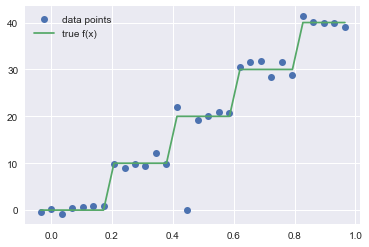

In [66]:
plt.plot(x_i,y,'o',label = 'data points')
plt.plot(x_i_cont,f_x_cont,label = 'true f(x)')
plt.legend()


### least squares

In [96]:
gamma = choose_gamma(x_i)
K = make_K_mat_rbf(x_i,gamma)
lambda_val = 1e-3

In [111]:
# Construct the problem.
alpha = Variable(n)
#cost = sum_squares(y - K*alpha) + lambda_val*np.dot(alpha.T,np.dot(K,alpha))
#cost = sum_squares(y - K*alpha) + lambda_val*alpha.T*K*alpha
cost = sum_squares(y - K*alpha) +  



objective = Minimize(cost)
prob = Problem(objective)

# The optimal objective is returned by prob.solve().
result = prob.solve()
# The optimal value for x is stored in x.value.
print(x.value)
# The optimal Lagrange multiplier for a constraint
# is stored in constraint.dual_value.
print(constraints[0].dual_value)

SolverError: Solver 'ECOS' failed. Try another solver.

### huber


In [ ]:
# Construct the problem.
x = Variable(n)
objective = Minimize(huber(A*x - b))
constraints = [0 <= x, x <= 1]
prob = Problem(objective, constraints)

# The optimal objective is returned by prob.solve().
result = prob.solve()
# The optimal value for x is stored in x.value.
print(x.value)
# The optimal Lagrange multiplier for a constraint
# is stored in constraint.dual_value.
print(constraints[0].dual_value)